# VR inserts Sanger verification

After running a gel comparing lengths of amplified VR insert fragment and vector that showed different lengths I submitted a number of sequences for Sanger sequencing. In this notebook I am verifiying the sequence content of submitted sequences.



In [92]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.SeqRecord import SeqRecord
from Bio.pairwise2 import format_alignment
from urllib import request
import re
import pandas as pd
from pydna.common_sub_strings import common_sub_strings
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Download and read all insert sequences.

In [2]:
INSERT_FASTA_URL = 'https://github.com/EthanHolleman/plasmid-VR-design/releases/download/v2.0/complete_inserts.fa'
insert_fasta = 'complete_inserts.fa'
with request.urlopen(INSERT_FASTA_URL) as f:
    content = f.read().decode('utf-8')
    with open(insert_fasta, 'w') as handle:
        handle.write(content)

inserts = list(SeqIO.parse(insert_fasta, 'fasta'))
print(len(inserts), 'inserts downloaded')

31 inserts downloaded


Read Sanger seq data.

In [3]:
sanger_path = '2021-08-20_714751_129407_data/all_text.fas'
sanger = list(SeqIO.parse(sanger_path, 'fasta'))
assert len(sanger) == 12  # submitted 12 sequences

In [4]:
sanger[0]

SeqRecord(seq=Seq('CCAGGGACCGCTCGAGGGTTCTTATCTCGGGGTTGTAGTTCTATCGTGCGGGTG...AAA'), id='VR-10_Variable_region_insert_primer_1_', name='VR-10_Variable_region_insert_primer_1_', description='VR-10_Variable_region_insert_primer_1_', dbxrefs=[])

Sanger data can be matched to the correct insert sequence using `VR-{number}` as a key.

In [5]:
INSERT_ID_RE = r'VR-\d+'

In [6]:
insert_dict = {re.search(INSERT_ID_RE, each_insert.description)[0]: each_insert for each_insert in inserts}

In [7]:
insert_sanger_dict = {}
for each_seq in sanger:
    name = re.search(INSERT_ID_RE, each_seq.description)[0]
    insert_sanger_dict[name] = insert_dict[name], each_seq

In [8]:
formated = format_alignment(*pairwise2.align.localxx(
    insert_sanger_dict['VR-29'][0].seq,
    insert_sanger_dict['VR-29'][1].seq
)[0])

open('test-vr-29.align', 'w').write(formated)

2265

Does not really make sense as `VR-10` was not a plasmid. How did sequencing return 1000 bp read? Ok, maybe sample mix up? Lets just find the best alignment.

In [9]:
def best_alignment(sanger_seq, inserts):
    best_score, best_insert, best_alignment = 0, None, None
    for each_insert in inserts:
        alignment = pairwise2.align.localxx(
            sanger_seq, each_insert.seq
        )[0]
        score = alignment.score
        if score > best_score:
            best_score, best_insert, best_alignment = score, each_insert, alignment
    return best_score, best_insert, best_alignment

score, best_insert, best_alignment = best_alignment(insert_sanger_dict['VR-29'][1], inserts)

In [10]:
len(insert_sanger_dict['VR-29'][1].seq)

727

Why are these more than twice as long as they should be?

In [11]:
insert_details = pd.read_csv('VR-inserts-info.tsv', sep='\t')
insert_details = insert_details.set_index('Name', drop=False)

Add length of each Sanger read if present.

In [12]:
insert_details["Sanger_read_length"] = 0
for each_name in insert_sanger_dict:
    insert_details.at[each_name, 'Sanger_read_length'] = len(insert_sanger_dict[each_name][1])
insert_details

,Name,DNA mass (ng),Vector,Lot number,Concentration (ng/ul),Date arrived,Sanger_read_length
Name,,,,,,,
VR-1,VR-1,300,0,3121280,50,8/18/21,0
VR-10,VR-10,500,0,3121289,50,8/18/21,1000
VR-11,VR-11,400,0,3121290,50,8/18/21,0
VR-12,VR-12,5000,1,3121291,50,8/18/21,1000
VR-13,VR-13,700,0,3121292,50,8/18/21,749
VR-14,VR-14,650,0,3121293,50,8/18/21,0
VR-15,VR-15,5000,1,3121294,50,8/18/21,0
VR-16,VR-16,5000,1,3121295,50,8/18/21,1000
VR-17,VR-17,5000,1,3121296,50,8/18/21,1000


In [13]:
%%R
library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(viridis)

R[write to console]: Loading required package: viridisLite



In [1]:
%%R -i insert_details -w 5 -h 5 --units in -r 200

inserts.seq <- subset(insert_details, Sanger_read_length > 0)
inserts.seq$Name <- as.character(inserts.seq$Name)

inserts.seq.vectors <- subset(inserts.seq, Vector==1)
inserts.seq.frags <- subset(inserts.seq, Vector==0)


length.plot <- function(df, title){
    
    ggplot(df, aes(x=Name, y=Sanger_read_length, fill=Name)) +
        geom_bar(stat='identity', color='black', size=1) +
        theme_pubr() + scale_fill_brewer(palette='Dark2') +
        theme(legend.position = "none") +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        labs(x='', y='Read length', title=title)
    
}

frags.plot <- length.plot(inserts.seq.frags, 'Fragments')
vectors.plot <- length.plot(inserts.seq.vectors, 'Vectors')
ggarrange(frags.plot, vectors.plot)

UsageError: Cell magic `%%R` not found.


In [101]:
def longest_substring(s1, s2):
    t = [[0]*(1+len(s2)) for i in range(1+len(s1))]
    l, xl = 0, 0
    for x in range(1,1+len(s1)):
        for y in range(1,1+len(s2)):
            if s1[x-1] == s2[y-1]:
                t[x][y] = t[x-1][y-1] + 1
                if t[x][y]>l:
                    l = t[x][y]
                    xl  = x
            else:
                t[x][y] = 0
    return s1[xl-l: xl]


def longest_substring_seqs(sanger, insert):
    sanger_seq = str(sanger.seq)
    insert_seq = str(insert.seq)
    insert_name = re.search(INSERT_ID_RE, insert.description)[0]
    sanger_name = re.search(INSERT_ID_RE, sanger.description)[0]
    lcss = longest_substring(sanger_seq, insert)
    return {
        'Sanger': sanger_name,
        'Insert': insert_name,
        'lcss': lcss,
        'length_lcss': len(lcss)
    }


def longest_substring_strings(string_a, a_name, string_b, b_name):
    lcss = longest_substring(string_a, string_b)
    return {
        'String_a': a_name,
        'String_b': b_name,
        'lcss': lcss,
        'length_lcss': len(lcss)
    }

In [16]:
def matrix_calc(x, y, func, *args):
    matrix = []
    for each_x in x:
        for each_y in y:
            results = func(each_x, each_y, *args)
            matrix.append(results)
    return pd.DataFrame(matrix)

lcss_matrix = matrix_calc(sanger, inserts, longest_substring_seqs)

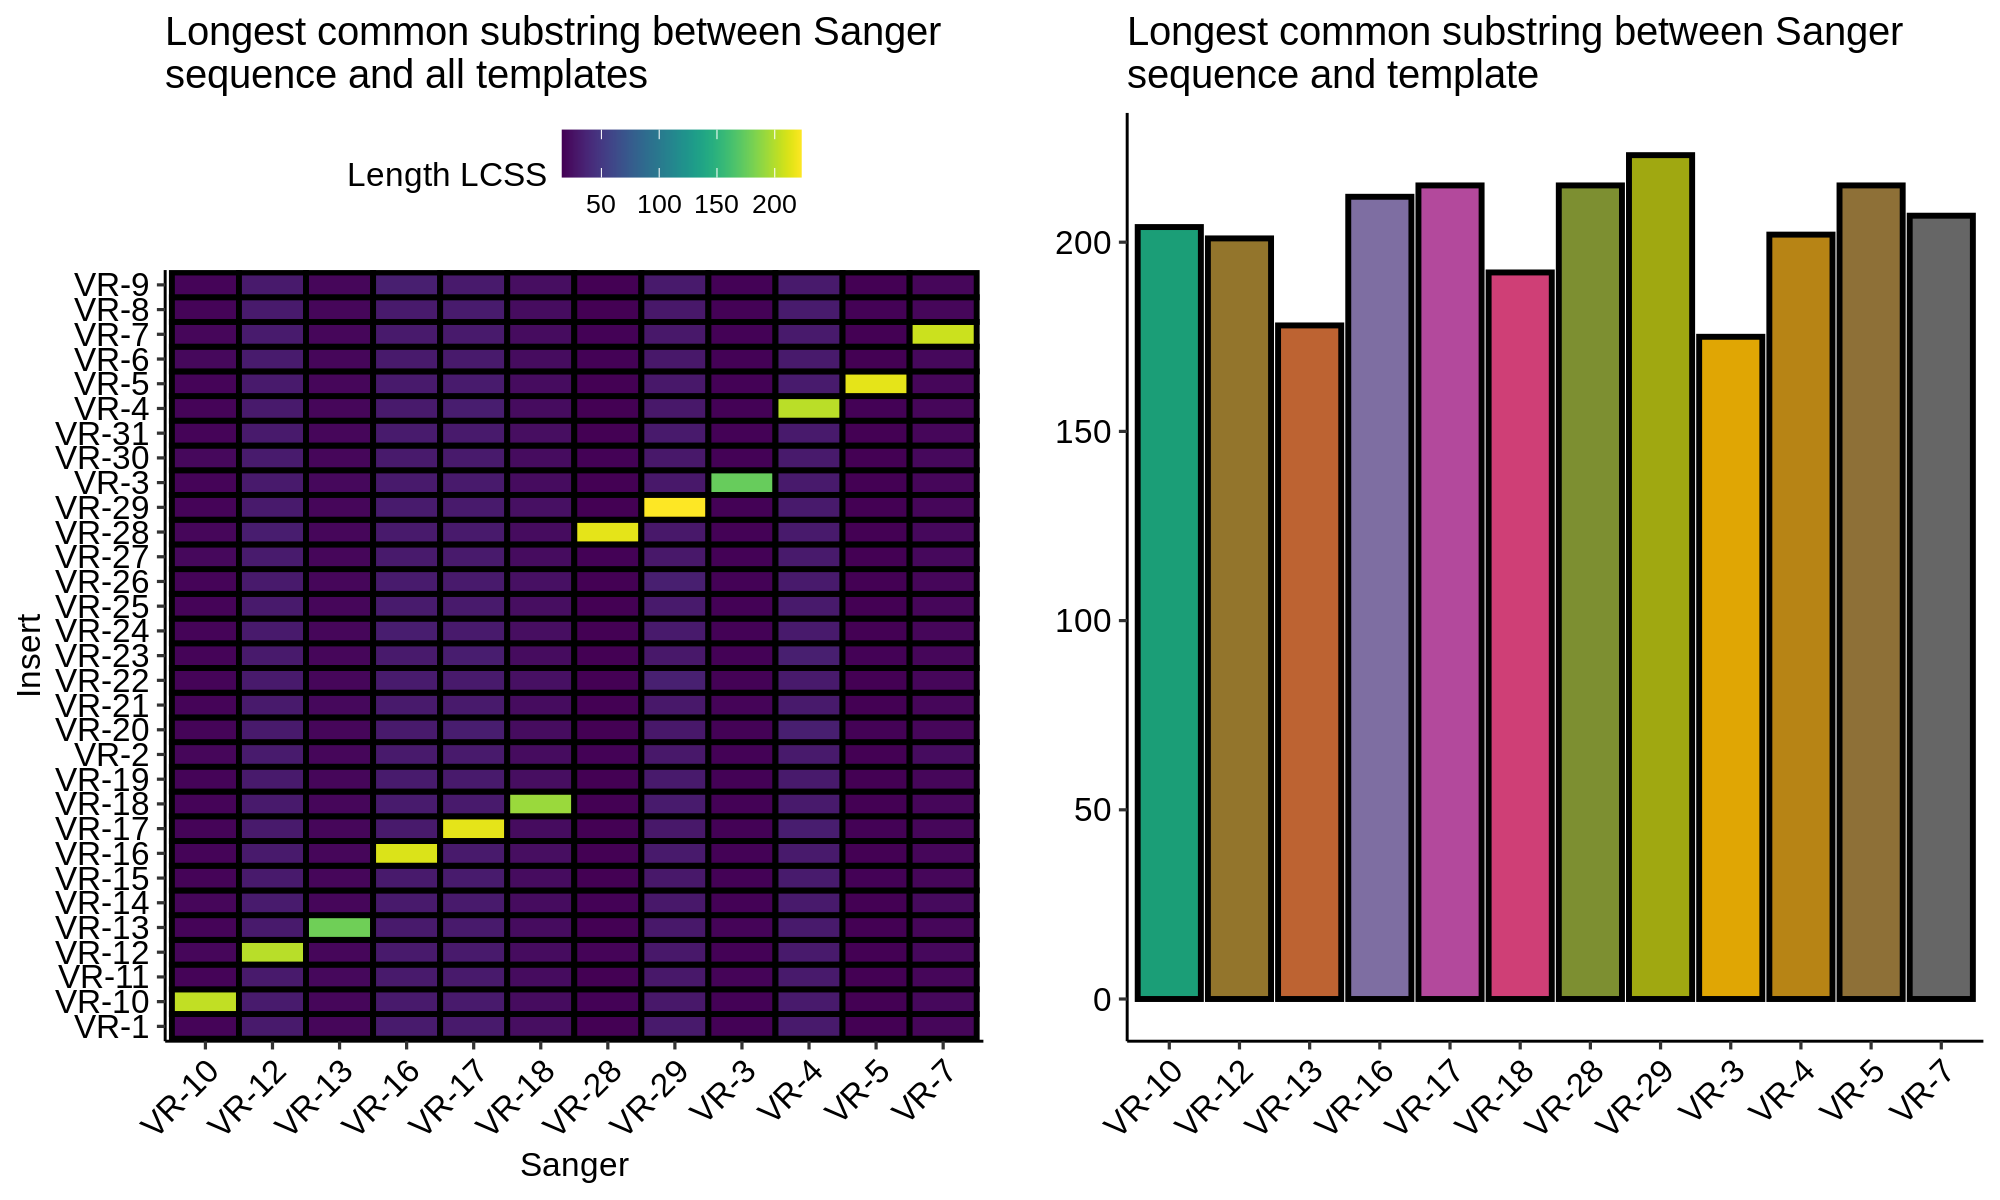

In [17]:
%%R -i lcss_matrix -w 10 -h 6 --units in -r 200

all.all.heatmap <- ggplot(lcss_matrix, aes(x=Sanger, y=Insert, fill=length_lcss)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between Sanger\nsequence and all templates') + 
                        scale_fill_viridis()

one.one <- subset(lcss_matrix, Sanger==Insert)

colors <- colorRampPalette(brewer.pal(8, "Dark2"))(length(one.one$Insert))

one.one.bars <- ggplot(one.one, aes(x=Insert, y=length_lcss, fill=Insert)) + 
                geom_bar(stat='identity', color='black', size=1) +
                theme_pubr() + scale_fill_manual(values=colors) +
                theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                theme(legend.position = "none") +
                labs(x='', y='', title='Longest common substring between Sanger\nsequence and template')
ggarrange(all.all.heatmap, one.one.bars)

In [18]:
# remove common substrings with the vector
lcss_sanger = matrix_calc(sanger, sanger, longest_substring_seqs)

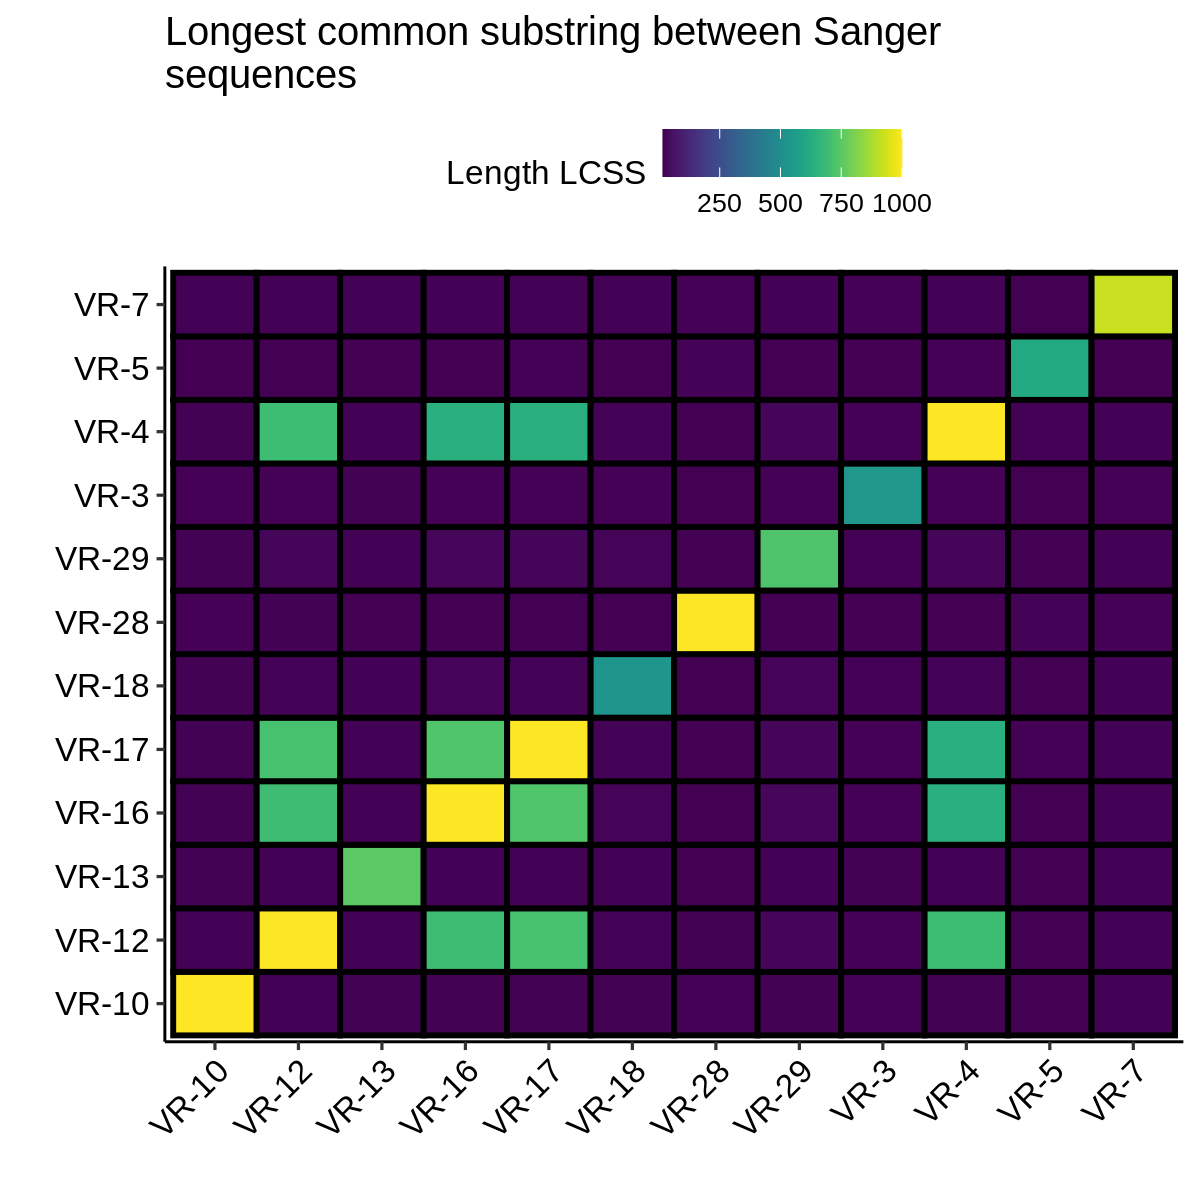

In [19]:
%%R -i lcss_sanger -w 6 -h 6 --units in -r 200

all.all.sanger.heatmap <- ggplot(lcss_sanger, aes(x=Sanger, y=Insert, fill=length_lcss)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between Sanger\nsequences',
                           x='', y='') + 
                        scale_fill_viridis()
all.all.sanger.heatmap

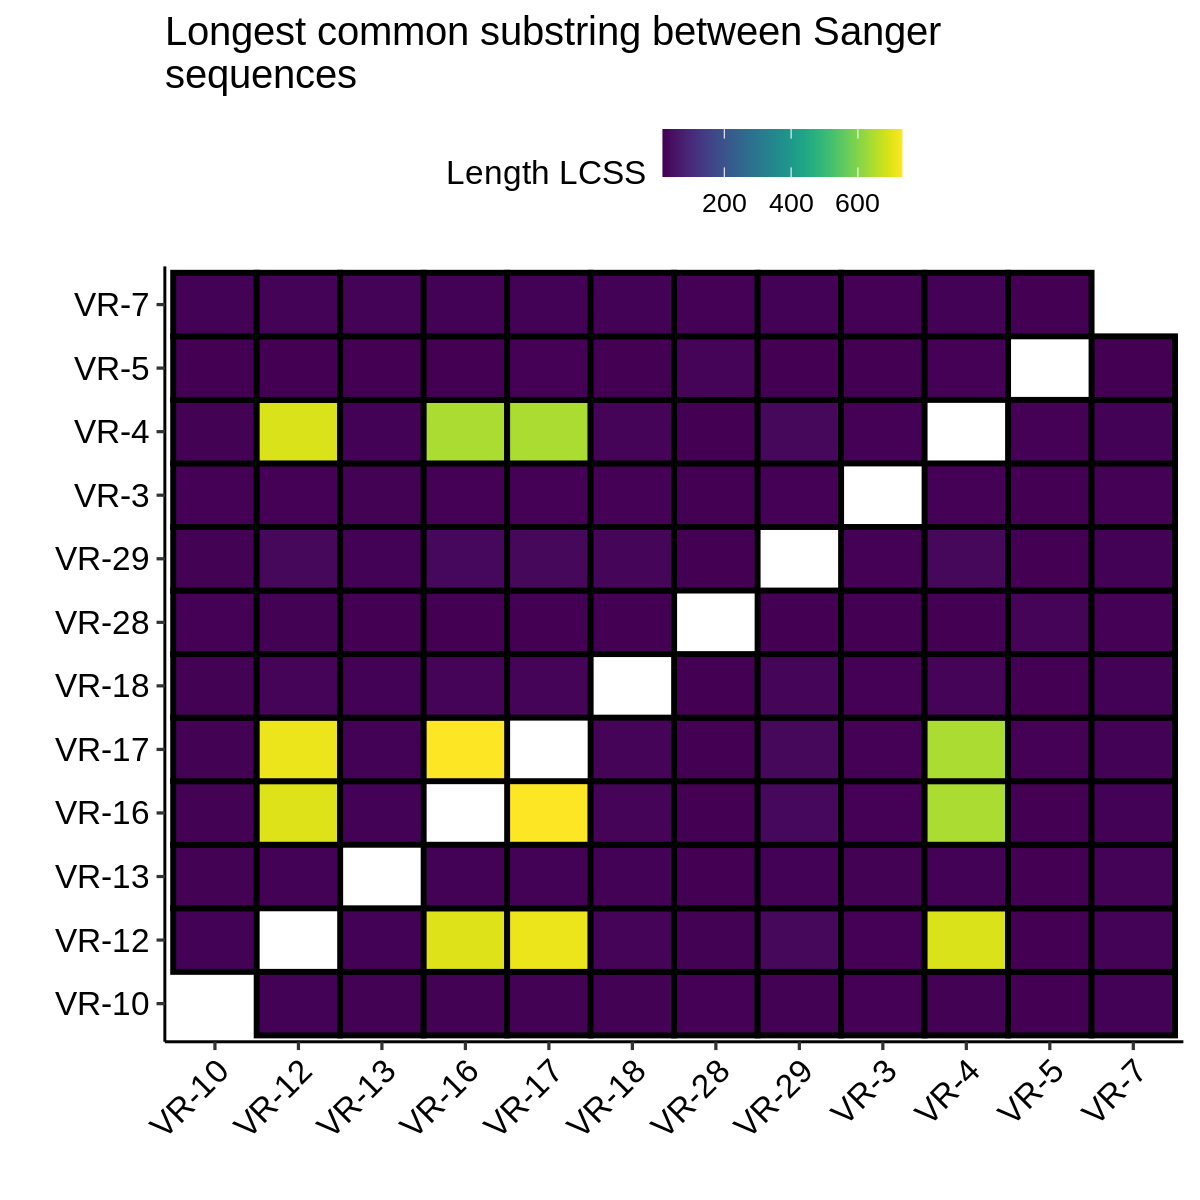

In [119]:
%%R -i lcss_sanger -w 6 -h 6 --units in -r 200

lcss_sanger.no_self <- subset(lcss_sanger, Sanger != Insert)

all.all.sanger.heatmap.no_self <- ggplot(lcss_sanger.no_self, aes(x=Sanger, y=Insert, fill=length_lcss)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between Sanger\nsequences',
                           x='', y='') + 
                        scale_fill_viridis()
all.all.sanger.heatmap.no_self

In [20]:
vector_id_seq = 'TGGGCCTCATGGGCCTTCCGCTCAC'  # occurs just after insert
vector_free_sanger = []
for each_seq in sanger:
    loc = each_seq.seq.find(vector_id_seq)
    if loc != - 1:
        length= len(each_seq.seq[:loc])
        vector = 1
    else:
        vector = 0
        length = len(each_seq.seq)
        
    name = re.search(INSERT_ID_RE, each_seq.description)[0]
    vector_free_sanger.append(
        {'Name': name,
        'Sanger_read_length': length,
         'Vector': vector
        }
    )
vector_free_df = pd.DataFrame(vector_free_sanger)
vector_free_df

,Name,Sanger_read_length,Vector
0,VR-10,1000,0
1,VR-12,288,1
2,VR-13,749,0
3,VR-16,269,1
4,VR-17,267,1
5,VR-18,534,0
6,VR-28,1000,0
7,VR-29,727,0
8,VR-3,541,0
9,VR-4,283,1


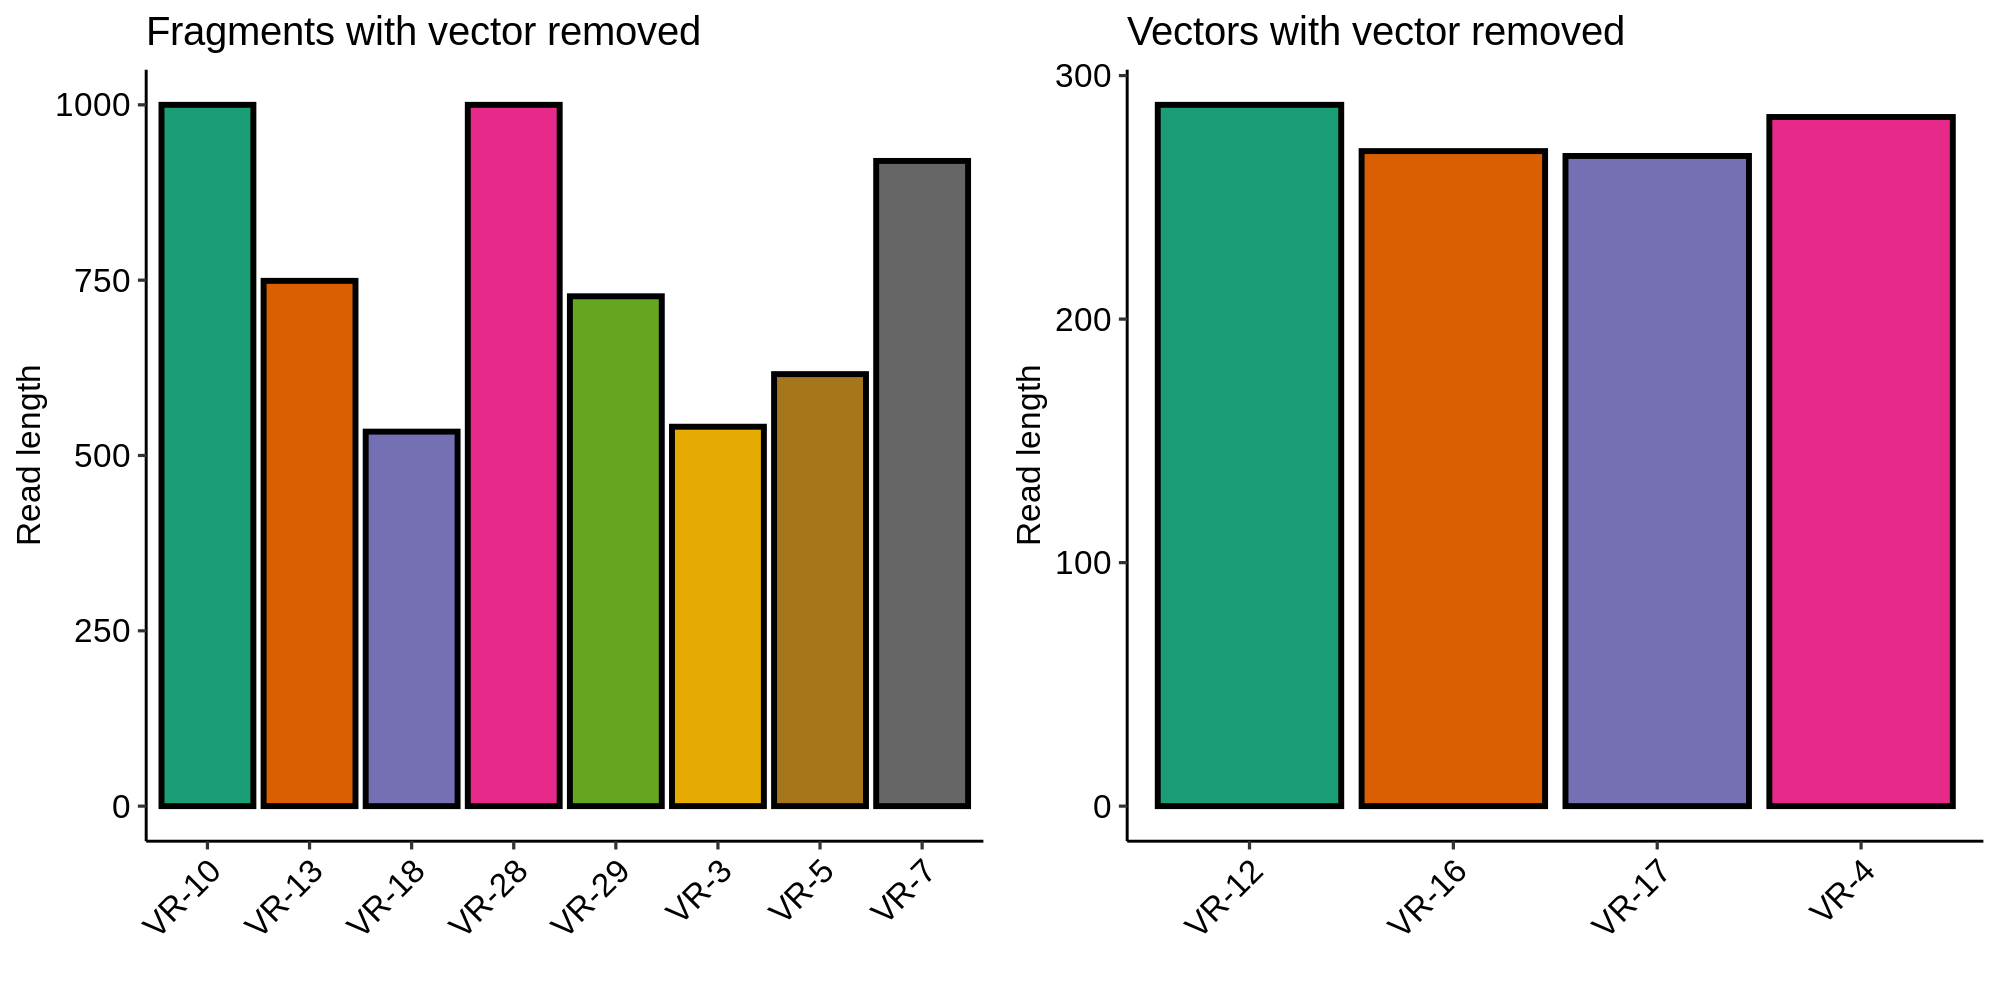

In [21]:
%%R -i vector_free_df -w 10 -h 5 --units in -r 200

vector_free_sanger.vector <- subset(vector_free_df, Vector==1)
vector_free_sanger.frag <- subset(vector_free_df, Vector==0)

length.plot <- function(df, title){
    
    ggplot(df, aes(x=Name, y=Sanger_read_length, fill=Name)) +
        geom_bar(stat='identity', color='black', size=1) +
        theme_pubr() + scale_fill_brewer(palette='Dark2') +
        theme(legend.position = "none") +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        labs(x='', y='Read length', title=title)
    
}

vector <- length.plot(vector_free_sanger.vector, 'Vectors with vector removed')
frag <- length.plot(vector_free_sanger.frag, 'Fragments with vector removed')

remove.vector.lengths <- ggarrange(frag, vector)
remove.vector.lengths

Why are fragments longer than vectors after removing vectors???

Additionally only full sanger vectors align to the vector without insert via SnapGene. All fragments fail to align

![](21ACQM5C_3121299_insert_VR-20_Map.png)

In [22]:
def sliding_window(seq, window_size, step):
    windows = []
    for i in range(0, len(seq)-window_size, step):
        windows.append(
            seq[i:i+window_size]
        )
    return windows

sliding_window(sanger[0].seq, 5, 1)

def kmer_count(seq, window_size, step):
    windows = sliding_window(seq, window_size, step)
    count_dict, df = {}, {}
    for each_window in windows:
        if each_window in count_dict:
            count_dict[each_window] +=1
        else:
            count_dict[each_window] = 1
    return pd.DataFrame(
        [{'kmer': str(window), 'count': count} for window, count in count_dict.items()]
    )
        
kmer_count(sanger[1].seq, 4, 1)

,kmer,count
0,GCGC,7
1,CGCT,18
2,GCTA,4
3,CTAG,2
4,TAGT,1
...,...,...
244,AGAA,2
245,AGTA,1
246,ATTT,1
247,TTTG,1


In [23]:

plot_windows <- function(kmer.df){
    
    ggplot(kmer.df, aes(x=kmer, y=count)) + geom_bar(stat='identity')
    
    
}

SyntaxError: invalid syntax (272082049.py, line 1)

In [33]:
def normalized_alignment_score(seq_a, seq_b):
    min_length = len(min(seq_a, seq_b, key=lambda s: len(s)))  # shortest seq defines max score
    seq_a_name = re.search(INSERT_ID_RE, seq_a.description)[0]
    seq_b_name = re.search(INSERT_ID_RE, seq_b.description)[0]
    score = pairwise2.align.localxx(
            seq_a, seq_b
        )[0].score / min_length
    return {
        'Seq_A': seq_a_name,
        'Seq_B': seq_b_name,
        'Score': score
    }

In [39]:
all_alignments = matrix_calc(sanger, inserts, normalized_alignment_score)
sanger_v_sanger = matrix_calc(sanger, sanger, normalized_alignment_score)

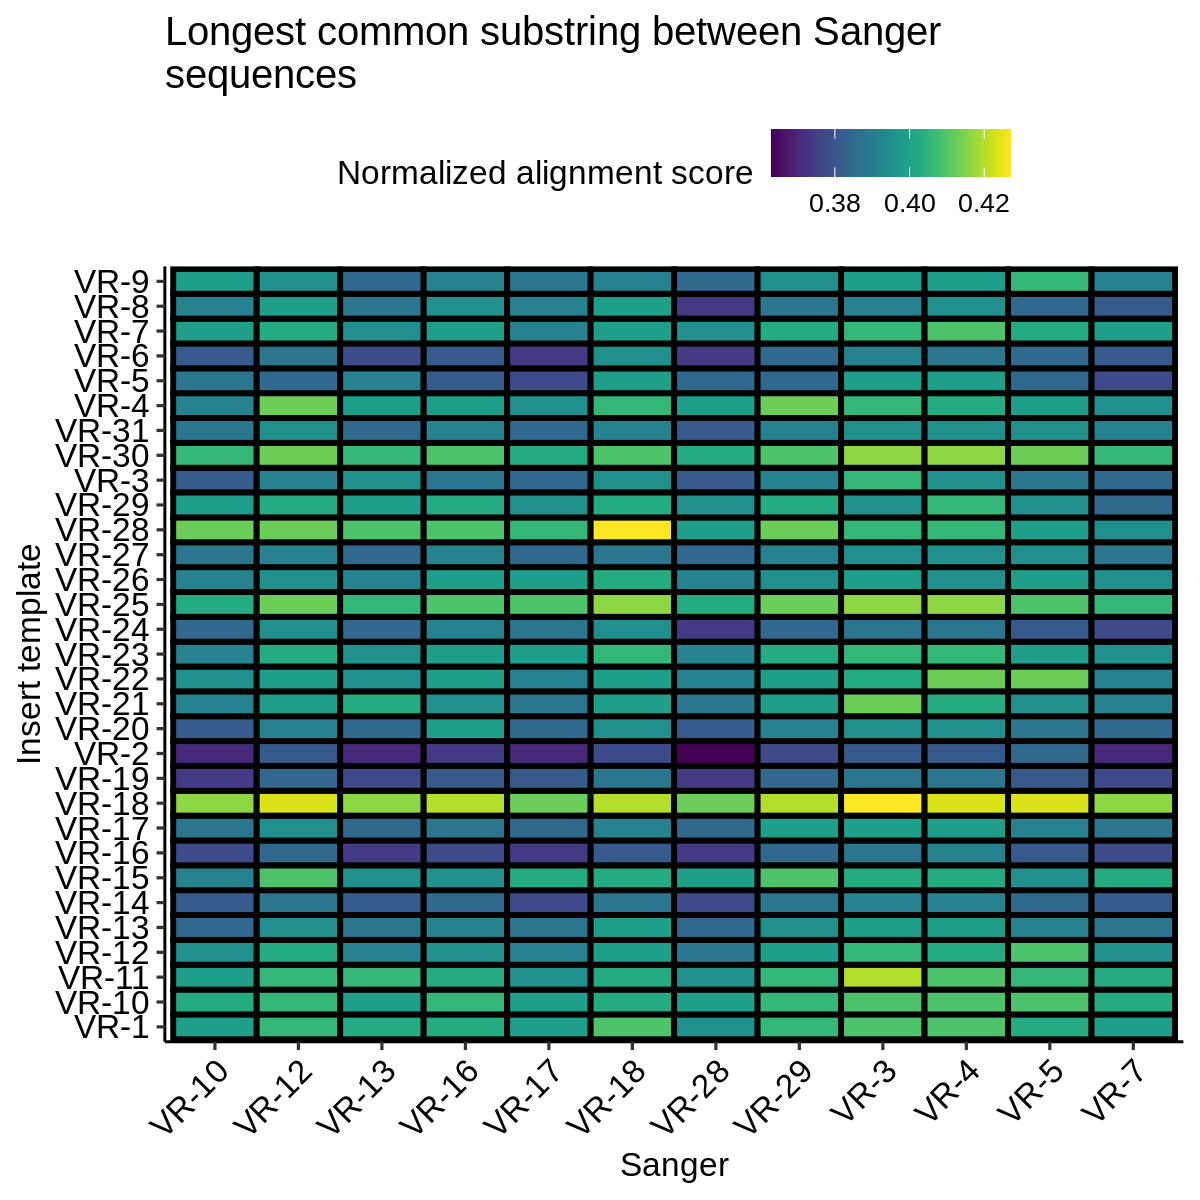

In [44]:
%%R -i all_alignments -w 6 -h 6 --units in -r 200

all.all.alignment <- ggplot(all_alignments, aes(x=Seq_A, y=Seq_B, fill=Score)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Normalized alignment score', 
                           title='Longest common substring between Sanger\nsequences',
                           x='Sanger', y='Insert template') + 
                        scale_fill_viridis()

all.all.alignment

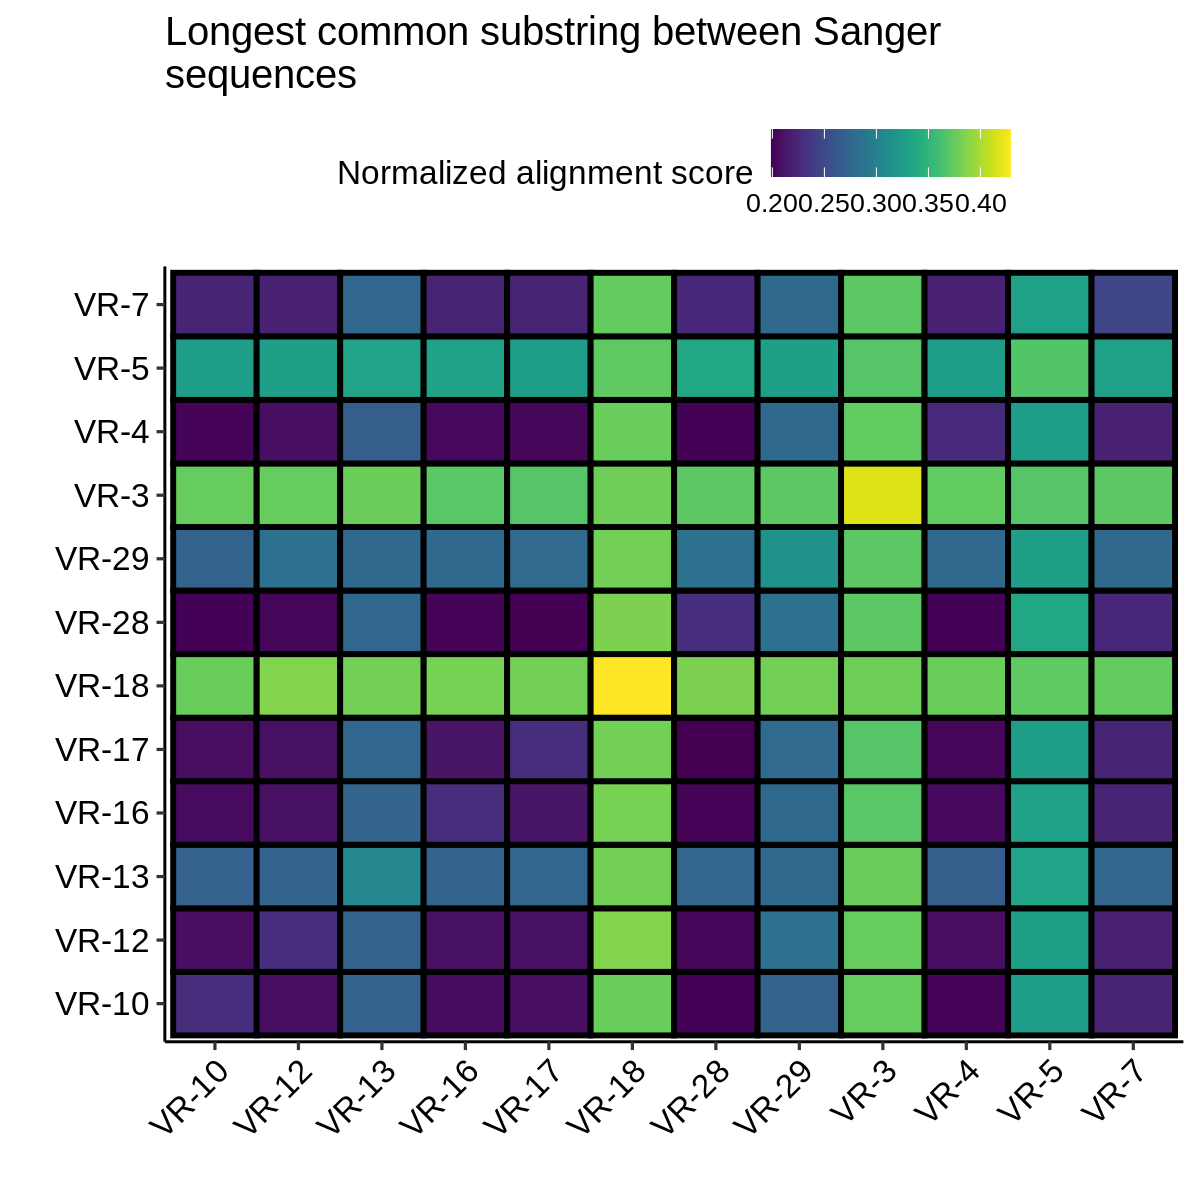

In [46]:
%%R -i sanger_v_sanger -w 6 -h 6 --units in -r 200


sanger.sanger.alignment <- ggplot(sanger_v_sanger, aes(x=Seq_A, y=Seq_B, fill=Score)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Normalized alignment score',
                           title='Longest common substring between Sanger\nsequences',
                           x='', y='') + 
                        scale_fill_viridis()

sanger.sanger.alignment 

Low alignment scores between the same sequences?

In [48]:
normalized_alignment_score(sanger[0], sanger[0])

{'Seq_A': 'VR-10', 'Seq_B': 'VR-10', 'Score': 0.229}

In [55]:
print(format_alignment(*pairwise2.align.globalxx(
            sanger[0], sanger[0]
        )[0]))

ID: VR-10_Variable_region_insert_primer_1_
Name: VR-10_Variable_region_insert_primer_1_
Description: VR-10_Variable_region_insert_primer_1_
Number of features: 0
Seq('CCAGGGACCGCTCGAGGGTTCTTATCTCGGGGTTGTAGTTCTATCGTGCGGGTG...AAA')
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
ID: VR-10_Variable_region_insert_primer_1_
Name: VR-10_Variable_region_insert_primer_1_
Description: VR-10_Variable_region_insert_primer_1_
Number of features: 0
Seq('CCAGGGACCGCTCGAGGGTTCTTATCTCGGGGTTGTAGTTCTATCGTGCGGGTG...AAA')
  Score=229



In [56]:
pairwise2.align.globalxx(
            'ATC', 'ATC'
        )

[Alignment(seqA='ATC', seqB='ATC', score=3.0, start=0, end=3)]

In [57]:
pairwise2.align.globalxx(
            sanger[0], sanger[0]
)

[Alignment(seqA="ID: VR-10_Variable_region_insert_primer_1_\nName: VR-10_Variable_region_insert_primer_1_\nDescription: VR-10_Variable_region_insert_primer_1_\nNumber of features: 0\nSeq('CCAGGGACCGCTCGAGGGTTCTTATCTCGGGGTTGTAGTTCTATCGTGCGGGTG...AAA')", seqB="ID: VR-10_Variable_region_insert_primer_1_\nName: VR-10_Variable_region_insert_primer_1_\nDescription: VR-10_Variable_region_insert_primer_1_\nNumber of features: 0\nSeq('CCAGGGACCGCTCGAGGGTTCTTATCTCGGGGTTGTAGTTCTATCGTGCGGGTG...AAA')", score=229.0, start=0, end=229)]

In [59]:
str(sanger[0].seq)

'CCAGGGACCGCTCGAGGGTTCTTATCTCGGGGTTGTAGTTCTATCGTGCGGGTGCATGCTGAGGTGCCCTACCGAGGGAGCGACCAACGCTATCTTAATGAACGCGGGCGTTTAGTGCGGTGTACGGTTGGGTAGAATACCCTTAGCTGATATATTGGCGCCAACGATTCACCGAAAAACACCTGCACTAACGCGGCATGATGATTGGAATGTATATAAGACTAAGTTTGGGAATTCGTCGCAGTGACCAGGGCGAGGAGGGAAGTCGTCATCGTCCGCTTGTGTTGTTCACGTCTTGCTTCTTGTTGATTTTTACGGCAACCAAGAATGTCAAATCCATACCCCGCCTGGCCCGGCCGGCCTGCCTGAGCCATCCATCCATGTGCCCTCCAGACCTTGCTTTCCTTCCTTTTCCTTATCCAATTTGACTTAGTTGAGGACCTGGGGTTGCTCTCTTCGGCTGGGGATCGAAACACGCCTCCCCATGCCGCCCATAGCAGTGAACCTCGTTTGGGTCTTTTTTCAATCAGCAGGGGGATTAAGCATTCGGGAAAGGCTCAGCCAGCCCCGCTGGCCTTGCTGGATGGCAAGACGGAATCACGATAGGGTTCGGCGTGGAAGATAGACCTAAAGATCCCAACCCACCGTCCACCCTTCGTACCGGCGCCTGATCGAGCAAGACATCTACGACCTCATACATCTGGAGCGCGGTTGTAAAGTATCAATCCTTGTCGTGCGTCTGGATGGTGGCTCATCCGATTCTGGCTATCTTAATGCATCTCTTCACACCTCGCCTCCACCAGGCCGATGCTGACTTGAACAGAGACATCAAGCAATACAGCCCTCTGGCCACATGCCCTTTGACAACTGGGCGAAGATCAGCGAATAAAATACAGGCTCTCGGAAGTGCTCTGCCTCCCCGTGCCGTAGTGTATCGCGATGACGTGATATGTCGAGCCCGACGCAATACCACCCACCTGAGAAAGCTTGCACCCTTAA

In [81]:
# want to get the end of the alignment to the template get that sequence and align all those sequences to each other

fragments = insert_details.loc[
        (insert_details['Vector'] == 0) & (insert_details['Sanger_read_length'] > 0)]
    
fragments

,Name,DNA mass (ng),Vector,Lot number,Concentration (ng/ul),Date arrived,Sanger_read_length
Name,,,,,,,
VR-10,VR-10,500,0,3121289,50,8/18/21,1000
VR-13,VR-13,700,0,3121292,50,8/18/21,749
VR-18,VR-18,650,0,312197,50,8/18/21,534
VR-28,VR-28,400,0,3121307,50,8/18/21,1000
VR-29,VR-29,800,0,3121308,50,8/18/21,727
VR-3,VR-3,650,0,3121282,50,8/18/21,541
VR-5,VR-5,650,0,3121284,50,8/18/21,616
VR-7,VR-7,700,0,3121286,50,8/18/21,920


In [84]:
fragment_names = list(fragments['Name'])

In [103]:
extra_seq_dict = {}  # store all the "extra stuff" from fragment sanger seq
for each_frag in fragment_names:
    alignment = pairwise2.align.localxx(
                insert_sanger_dict[each_frag][0], insert_sanger_dict[each_frag][1]
            )[0]
    # second sequence is the sanger seq
    extra = insert_sanger_dict[each_frag][1].seq[alignment.end:]
    extra_seq_dict[each_frag] = SeqRecord(
                                    extra, name=each_frag, 
                                    description=insert_sanger_dict[each_frag][0].description
                                )
extra_seq_dict

{'VR-10': SeqRecord(seq=Seq('GAATGTCAAATCCATACCCCGCCTGGCCCGGCCGGCCTGCCTGAGCCATCCATC...AAA'), id='<unknown id>', name='VR-10', description='_99C-nomyNl0HYInMs-TgDqnmjs insert_VR-10', dbxrefs=[]),
 'VR-13': SeqRecord(seq=Seq('CTGTTGATCTCCTGGGCACGACGGCTAACGGAGGCCCTTGGGCTACGTTCCCGT...GTT'), id='<unknown id>', name='VR-13', description='bD3U4vP9v7J6cRWRdRlcnEpk7IQ insert_VR-13', dbxrefs=[]),
 'VR-18': SeqRecord(seq=Seq('TTGGGAGACAAGGTAGTTGGGGGATTCCCGGCTGGGCCGGCGCCGGCGGCCTGG...GGG'), id='<unknown id>', name='VR-18', description='AILo-_aSL-cawXYINQVHNmLNr9g insert_VR-18', dbxrefs=[]),
 'VR-28': SeqRecord(seq=Seq('CCCTGCCCGAAGGGCTGGGTGAGCCATCCCGTTGCGTTTCGGAGCGTGTTTTCT...GTC'), id='<unknown id>', name='VR-28', description='F9X10junk8VgEYoX6qs4hD_xylg insert_VR-28', dbxrefs=[]),
 'VR-29': SeqRecord(seq=Seq('GAGGCGAGGAGAATTCGTCCCAGTGACCGAGGCGAGGCCAATTCTTTTCCTTTC...TCG'), id='<unknown id>', name='VR-29', description='8AW49NZ9SiR8pWC1Eb4o21XQOpw insert_VR-29', dbxrefs=[]),
 'VR-3': SeqRecord(seq=Se

In [104]:
extra_matrix = matrix_calc(extra_seq_dict.values(), inserts, longest_substring_seqs)

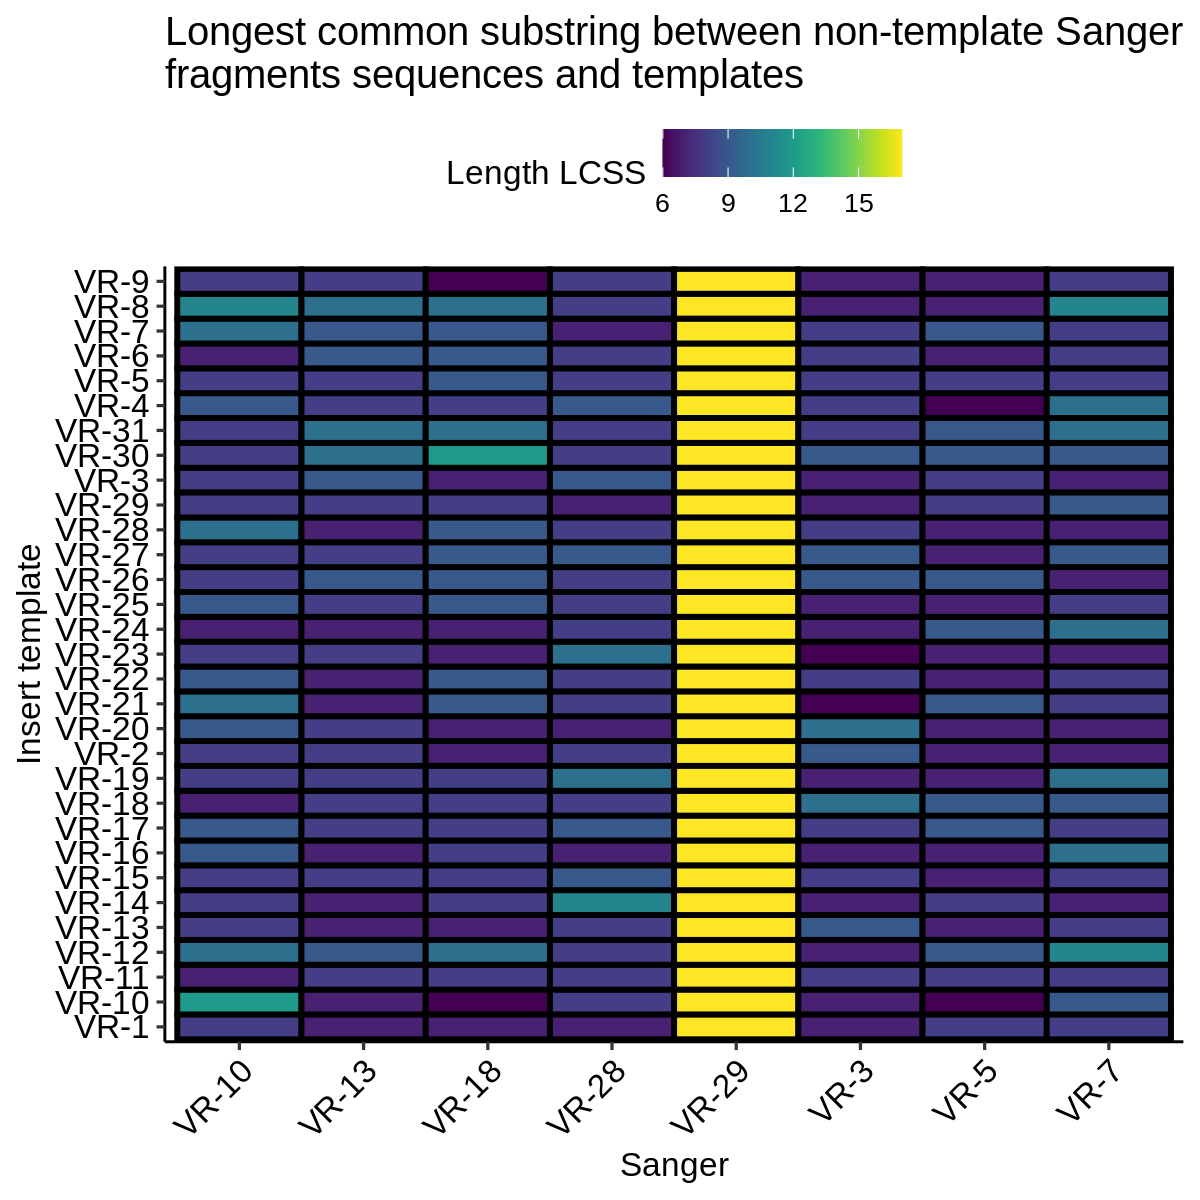

In [110]:
%%R -i extra_matrix -w 6 -h 6 --units in -r 200

extra.heatmap <- ggplot(extra_matrix, aes(x=Sanger, y=Insert, fill=length_lcss)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between non-template Sanger\nfragments sequences and templates',
                           x='Sanger', y='Insert template') + 
                        scale_fill_viridis()
extra.heatmap 

In [111]:
# compare extra sequences to themselves
extra_matrix_extra = matrix_calc(extra_seq_dict.values(), extra_seq_dict.values(), longest_substring_seqs)

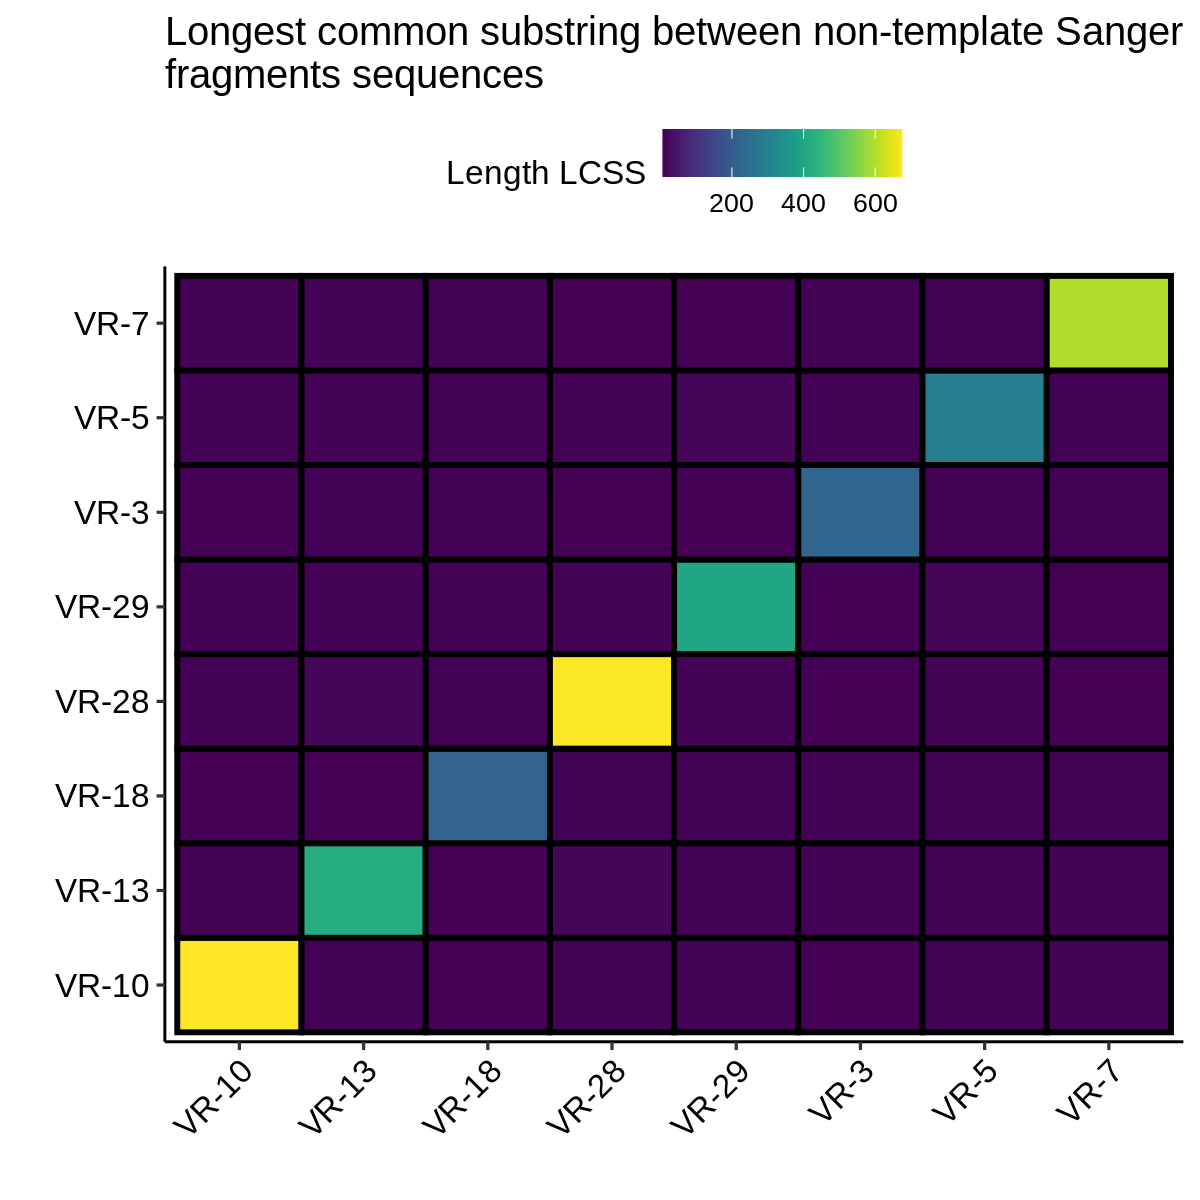

In [113]:
%%R -i extra_matrix_extra -w 6 -h 6 --units in -r 200

extra.extra.heatmap <- ggplot(extra_matrix_extra, aes(x=Sanger, y=Insert, fill=length_lcss)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between non-template Sanger\nfragments sequences',
                           x='', y='') + 
                        scale_fill_viridis()
extra.extra.heatmap 

Same thing as above but do not make self comparisons

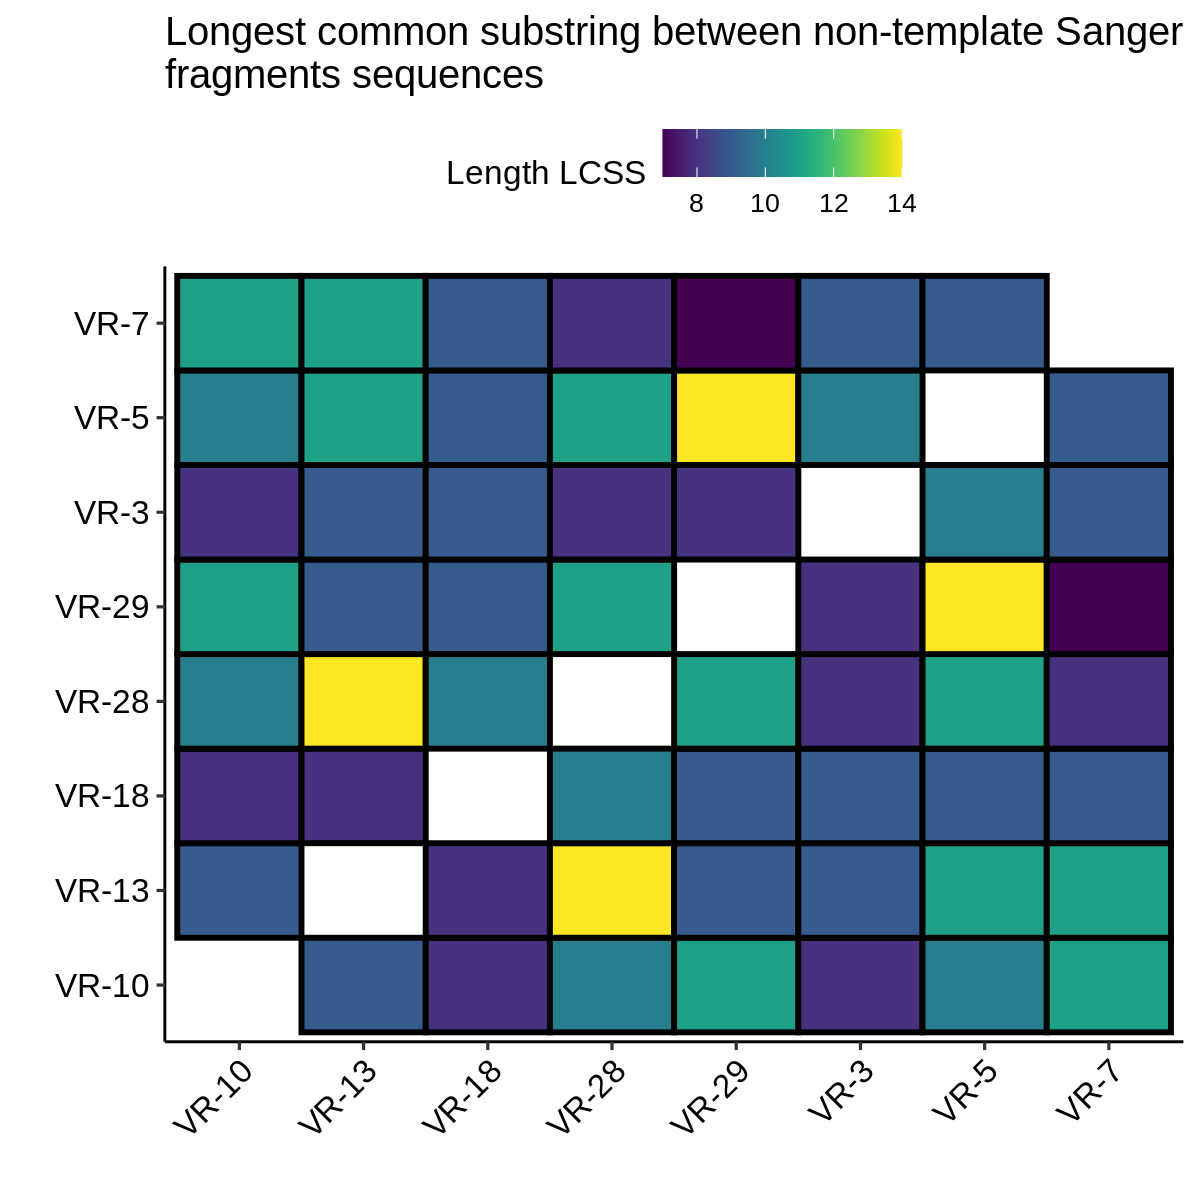

In [118]:
%%R -i extra_matrix_extra -w 6 -h 6 --units in -r 200

eme.no_self <- subset(extra_matrix_extra, Insert!=Sanger)

extra.extra.no_self <- ggplot(eme.no_self, aes(x=Sanger, y=Insert, fill=length_lcss)) + 
                       geom_tile(color='black', size=1) + theme_pubr() + 
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between non-template Sanger\nfragments sequences',
                           x='', y='') + 
                        scale_fill_viridis()
extra.extra.no_self

Same thing as above but as boxplot.

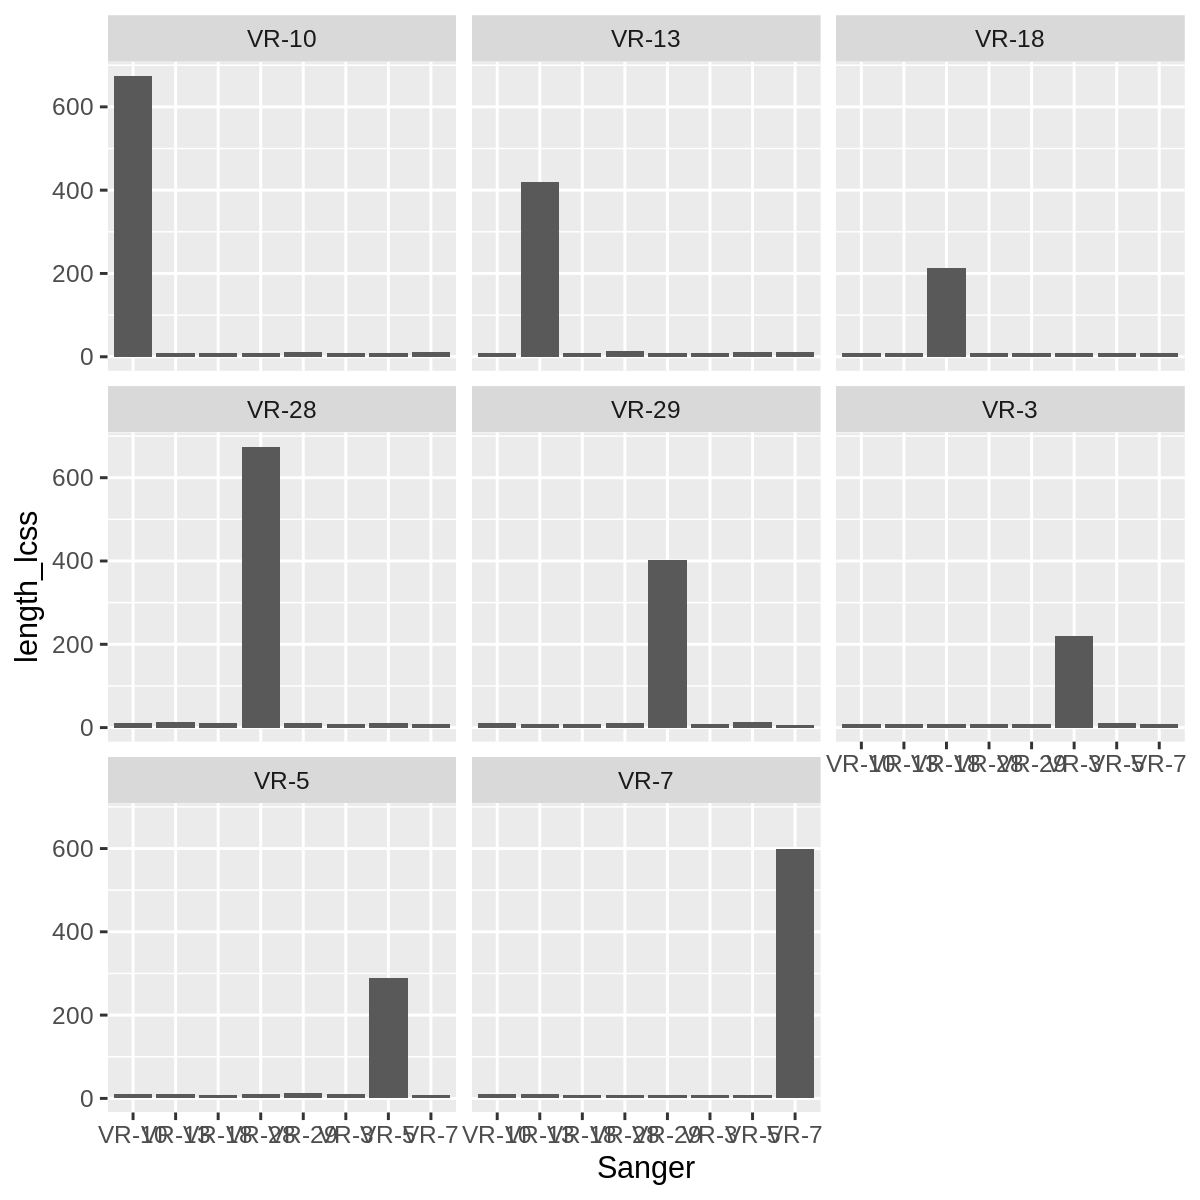

In [116]:
%%R -i extra_matrix_extra -w 6 -h 6 --units in -r 200

extra.extra.boxplot <- ggplot(extra_matrix_extra, aes(x=Sanger, y=length_lcss)) + 
                      geom_bar(stat='identity') + facet_wrap(~Insert)
                       theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
                       labs(
                           fill='Length LCSS', 
                           title='Longest common substring between non-template Sanger\nfragments sequences and templates',
                           x='Sanger', y='Insert template')
extra.extra.boxplot

In [121]:
insert_details.loc[
        insert_details['Sanger_read_length'] > 0]

,Name,DNA mass (ng),Vector,Lot number,Concentration (ng/ul),Date arrived,Sanger_read_length
Name,,,,,,,
VR-10,VR-10,500,0,3121289,50,8/18/21,1000
VR-12,VR-12,5000,1,3121291,50,8/18/21,1000
VR-13,VR-13,700,0,3121292,50,8/18/21,749
VR-16,VR-16,5000,1,3121295,50,8/18/21,1000
VR-17,VR-17,5000,1,3121296,50,8/18/21,1000
VR-18,VR-18,650,0,312197,50,8/18/21,534
VR-28,VR-28,400,0,3121307,50,8/18/21,1000
VR-29,VR-29,800,0,3121308,50,8/18/21,727
VR-3,VR-3,650,0,3121282,50,8/18/21,541


In [143]:
ab1_test = '2021-08-20_714751_129407_data/VR-29_Variable_region_insert_primer_1__2021-08-21_F08.ab1'

from Bio import SeqIO
handle = open(ab1_test, "rb")
records = SeqIO.parse(handle, "abi")
with open("example.fastq", "w") as output_handle:
    SeqIO.write(records, output_handle, "fastq")
ord('*')-33

9

In [156]:
a = list(SeqIO.parse('example.fastq', 'fastq-sanger'))[0]
a.name
a.description

'VR-29_Variable_region_insert_primer_1_'

In [154]:
for i, j in zip(a.seq, a.letter_annotations['phred_quality']):
    print(i, j)

T 3
T 2
G 2
C 3
A 5
T 5
A 5
A 4
C 4
G 7
T 4
A 4
C 6
A 4
T 4
A 6
C 14
T 11
C 4
C 7
T 8
C 10
G 18
G 24
A 8
G 12
G 28
T 21
G 28
A 29
C 16
C 51
T 48
T 40
G 29
G 20
G 22
A 26
G 16
A 18
T 14
C 29
A 25
G 29
G 38
T 35
A 35
G 14
A 43
G 27
A 38
A 31
C 37
G 42
T 27
T 32
A 24
G 18
G 22
T 27
A 37
T 32
G 56
G 39
C 38
A 44
G 56
G 62
G 59
G 62
A 59
A 49
T 59
A 62
G 62
A 62
G 62
A 59
C 59
G 49
G 54
T 62
C 62
T 54
G 62
G 62
G 54
C 62
T 62
C 62
T 62
T 62
C 62
T 62
C 59
A 49
G 62
A 62
T 62
G 62
A 59
T 59
T 62
T 54
A 62
T 62
T 62
T 59
A 62
A 62
G 62
A 62
G 62
T 62
T 62
G 62
G 62
G 62
A 62
G 62
A 62
A 62
G 62
C 59
T 62
G 62
A 59
T 59
G 62
G 62
T 62
A 62
T 62
A 62
G 62
T 62
G 62
G 62
G 62
A 59
G 62
A 59
T 59
T 62
A 62
G 62
G 62
A 62
A 62
A 62
T 62
C 62
T 62
T 62
G 62
T 62
A 62
G 62
G 62
T 62
G 62
A 62
G 62
G 62
G 62
T 62
G 62
G 62
T 62
A 62
G 62
G 62
C 62
G 62
G 62
T 62
G 59
G 62
A 59
A 62
G 62
G 62
A 62
A 62
T 62
C 62
G 54
G 62
T 62
G 62
C 62
A 62
T 62
G 62
C 62
G 62
A 59
G 62
T 62
C 62
A 62
T 62
T 62
C 62


In [153]:
a.letter_annotations

{'phred_quality': [3,
  2,
  2,
  3,
  5,
  5,
  5,
  4,
  4,
  7,
  4,
  4,
  6,
  4,
  4,
  6,
  14,
  11,
  4,
  7,
  8,
  10,
  18,
  24,
  8,
  12,
  28,
  21,
  28,
  29,
  16,
  51,
  48,
  40,
  29,
  20,
  22,
  26,
  16,
  18,
  14,
  29,
  25,
  29,
  38,
  35,
  35,
  14,
  43,
  27,
  38,
  31,
  37,
  42,
  27,
  32,
  24,
  18,
  22,
  27,
  37,
  32,
  56,
  39,
  38,
  44,
  56,
  62,
  59,
  62,
  59,
  49,
  59,
  62,
  62,
  62,
  62,
  59,
  59,
  49,
  54,
  62,
  62,
  54,
  62,
  62,
  54,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  59,
  49,
  62,
  62,
  62,
  62,
  59,
  59,
  62,
  54,
  62,
  62,
  62,
  59,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  59,
  62,
  62,
  59,
  59,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  59,
  62,
  59,
  59,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
  62,
 